In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
data = pd.read_csv("data/AirPassengers.csv")
print(data.dtypes)

Month         object
Passengers     int64
dtype: object


In [4]:
data['Month'] = pd.to_datetime(data['Month'])
print(data.dtypes)

Month         datetime64[ns]
Passengers             int64
dtype: object


In [5]:
data.set_index('Month', inplace=True)

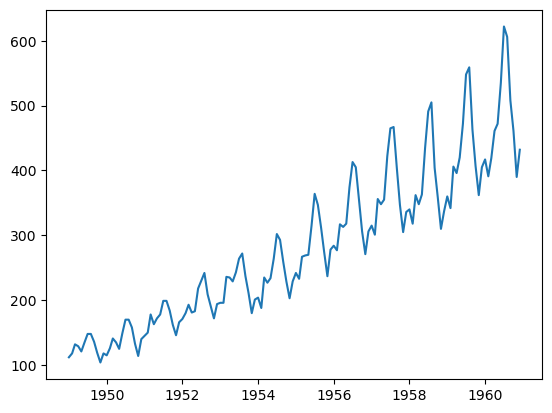

In [6]:
plt.plot(data['Passengers'])

In [12]:
#Is the data stationary?
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(data)
#Not stationary...

(0.01, False)

In [15]:
#Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(data)
print("pvalue = ", pvalue, " if above 0.05, data is not stationary")
#Since data is not stationary, we may need SARIMA and not just ARIMA

pvalue =  0.991880243437641  if above 0.05, data is not stationary


In [13]:
#Extract and plot trend, seasonal and residuals. 

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposed = seasonal_decompose(data['Passengers'], model = 'additive')

In [9]:
trend = decomposed.trend
seasonal = decomposed.seasonal
residual = decomposed.resid

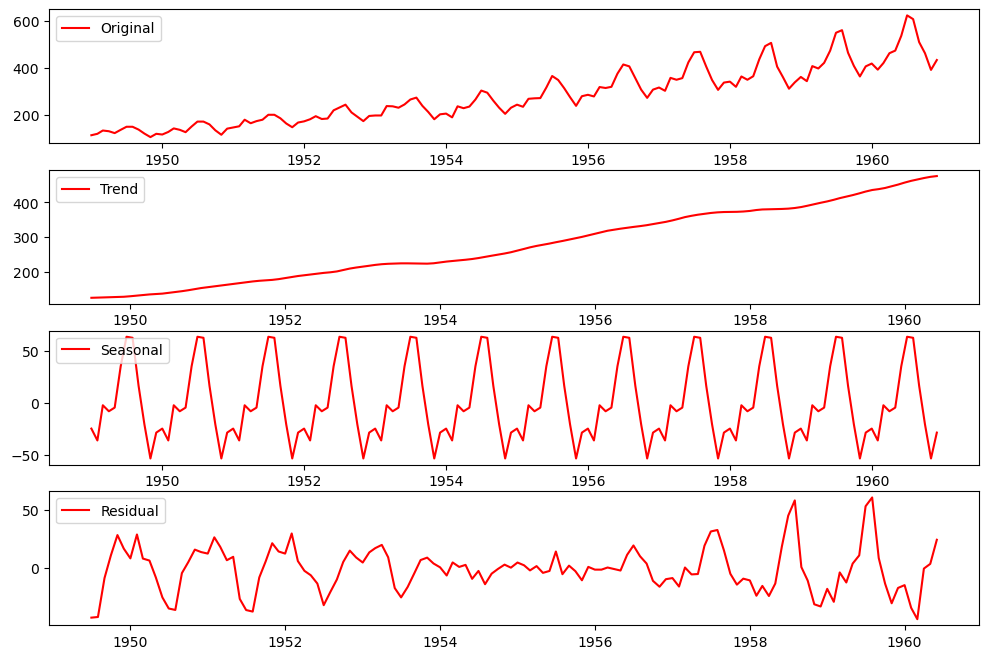

In [10]:
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(data, label='Original', color='red')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='red')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='red')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual', color='red')
plt.legend(loc='upper left')
plt.show()

In [16]:
#We can go through the exercise of making the data stationary and performing ARIMA
#Or let auto_arima provide the best model (e.g. SARIMA) and parameters. 
#Auto arima suggests best model and parameters based on 
#AIC metric (relative quality of statistical models)

In [17]:
from pmdarima.arima import auto_arima

In [18]:
#Autoarima gives us bet model suited for the data
# p - number of autoregressive terms (AR)
# q - Number of moving avergae terms (MA)
# d - number of non-seasonal differences
#p, d, q represent non-seasonal components
#P, D, Q represent seasonal components

In [20]:
arima_model = auto_arima(data['Passengers'], start_p = 1, d=1, start_q = 1, 
                          max_p = 5, max_q = 5, max_d=5, m = 12, 
                          start_P = 0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5,
                          seasonal = True, 
                          trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True, n_fits=50)  

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1022.393, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.16 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1020.393, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1019.239, Time=0.25 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=1020.582, Time=0.58 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.05 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1020.493, Time=0.42 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=3.64 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1032.120, Time=0.26 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1021.120, Time=0.48 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1021.032, Time=0.71 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1019.178, Time=0.40 sec
 ARIMA(0,1,1)(1,1,0)[12]     

In [21]:
# To print the summary 
print(arima_model.summary() ) #Note down the Model and details.
# Model: SARIMAX(0, 1, 1)x(2, 1, [], 12)

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -505.589
Date:                             Sun, 03 Sep 2023   AIC                           1019.178
Time:                                     21:54:46   BIC                           1030.679
Sample:                                 01-01-1949   HQIC                          1023.851
                                      - 12-01-1960                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3634      0.074     -4.945      0.000      -0.508      -0.219
ar.S.L12      -0.1239      

In [22]:
#Split data into train and test
size = int(len(data) * 0.66)
X_train, X_test = data[0:size], data[size:len(data)]

In [23]:
# Fit a SARIMAX(0, 1, 1)x(2, 1, 1, 12) on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model = SARIMAX(X_train['Passengers'],  
                order = (0, 1, 1),  
                seasonal_order =(2, 1, 1, 12)) 
  
result = model.fit() 
result.summary() 

C:\Users\sazid\anaconda3\envs\pioneer\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Passengers   No. Observations:                   95
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -300.268
Date:                            Sun, 03 Sep 2023   AIC                            610.537
Time:                                    21:55:51   BIC                            622.571
Sample:                                01-01-1949   HQIC                           615.368
                                     - 11-01-1956                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3191      0.103     -3.091      0.002      -0.521      -0.117
ar.S.L12       0.6861      0.567      1.210      0.226      -0.426       1.798
ar.S.L24       0.3128      0.133      2.353      0.019       0.052       0.573
ma.S.L12      -0.9820      5.371     -0.183      0.855     -11.510       9.546
sigma2        78.5811    377.900      0.208      0.835    -662.090     819.252
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.55
Prob(Q):                              0.95   Prob(JB):                         0.28
Heteroskedasticity (H):               1.68   Skew:                             0.42
Prob(H) (two-sided):                  0.18   Kurtosis:                         2.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
#Train prediction
start_index = 0
end_index = len(X_train)-1
train_prediction = result.predict(start_index, end_index) 

In [25]:
print(train_prediction)

1949-01-01      0.000000
1949-02-01    111.998307
1949-03-01    117.999819
1949-04-01    131.999577
1949-05-01    129.000091
                 ...    
1956-07-01    419.538811
1956-08-01    398.683508
1956-09-01    365.440653
1956-10-01    320.672268
1956-11-01    274.807190
Freq: MS, Name: predicted_mean, Length: 95, dtype: float64


In [27]:
#Prediction
start_index = len(X_train)
end_index = len(data)-1
prediction = result.predict(start_index, end_index).rename('Predicted passengers') #Rename the column

In [28]:
print(prediction)

1956-12-01    311.108833
1957-01-01    320.245731
1957-02-01    310.939372
1957-03-01    351.845488
1957-04-01    349.858769
1957-05-01    355.038988
1957-06-01    411.849044
1957-07-01    457.016432
1957-08-01    445.031054
1957-09-01    395.778356
1957-10-01    347.064024
1957-11-01    309.198396
1957-12-01    352.280631
1958-01-01    361.380260
1958-02-01    351.117024
1958-03-01    394.521674
1958-04-01    392.039531
1958-05-01    398.594614
1958-06-01    459.401305
1958-07-01    505.672352
1958-08-01    493.767673
1958-09-01    440.335695
1958-10-01    388.376546
1958-11-01    349.170306
1958-12-01    394.013946
1959-01-01    404.069232
1959-02-01    392.428013
1959-03-01    437.830437
1959-04-01    435.638125
1959-05-01    443.192927
1959-06-01    506.995250
1959-07-01    555.952733
1959-08-01    542.856790
1959-09-01    486.791005
1959-10-01    432.694820
1959-11-01    391.672359
1959-12-01    438.654654
1960-01-01    449.353995
1960-02-01    436.467975
1960-03-01    484.022697


<Axes: xlabel='Month'>

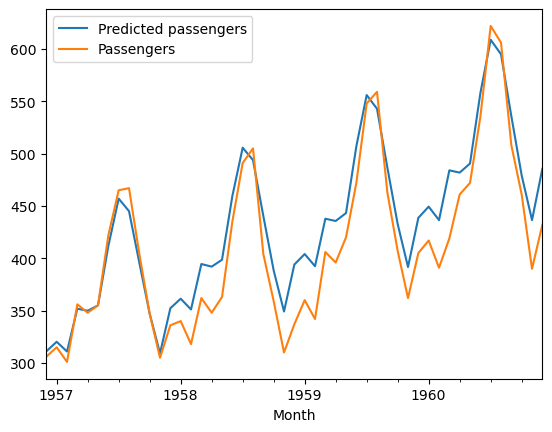

In [29]:
# plot predictions and actual values 
prediction.plot(legend = True) 
X_test['Passengers'].plot(legend = True) 

In [30]:
import math
from sklearn.metrics import mean_squared_error
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(X_train, train_prediction))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(X_test, prediction))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 16.14 RMSE
Test Score: 29.40 RMSE


In [31]:
from sklearn.metrics import r2_score
score = r2_score(X_test, prediction)
print("R2 score is: ", score)

R2 score is:  0.8593052328544372


In [32]:
#Forecast.. 
#We can re-train on the entire dataset before forecasting
#For now let us use the trained model
# Forecast for the next 3 years 
forecast = result.predict(start = len(data),  
                          end = (len(data)-1) + 3 * 12,  
                          typ = 'levels').rename('Forecast') 

C:\Users\sazid\anaconda3\envs\pioneer\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [33]:
print(forecast)

1961-01-01    496.906063
1961-02-01    482.734901
1961-03-01    532.391305
1961-04-01    530.363662
1961-05-01    540.112921
1961-06-01    610.425940
1961-07-01    663.913851
1961-08-01    649.109637
1961-09-01    586.968607
1961-10-01    528.020158
1961-11-01    483.621272
1961-12-01    534.675820
1962-01-01    546.825786
1962-02-01    531.383462
1962-03-01    583.155154
1962-04-01    581.224110
1962-05-01    592.062424
1962-06-01    665.608592
1962-07-01    721.387958
1962-08-01    705.707365
1962-09-01    640.560612
1962-10-01    579.209191
1962-11-01    533.115412
1962-12-01    586.210553
1963-01-01    599.079264
1963-02-01    582.362752
1963-03-01    636.243235
1963-04-01    634.416252
1963-05-01    646.339149
1963-06-01    723.106274
1963-07-01    781.190458
1963-08-01    764.621977
1963-09-01    696.486735
1963-10-01    632.744898
1963-11-01    584.953014
1963-12-01    640.090738
Freq: MS, Name: Forecast, dtype: float64


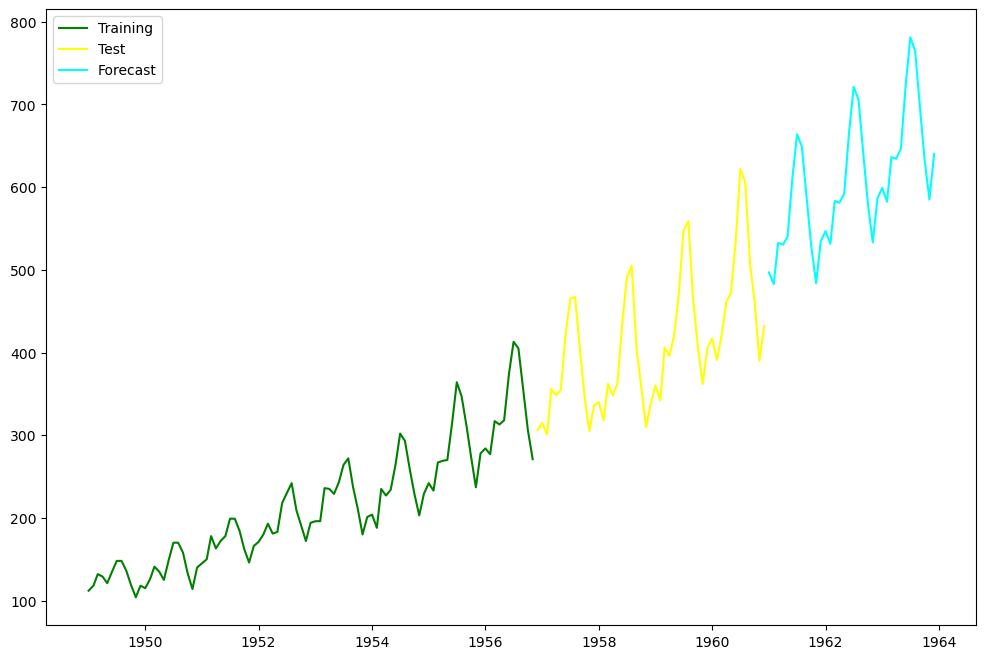

In [37]:
plt.figure(figsize=(12,8))
plt.plot(X_train, label='Training', color='green')
plt.plot(X_test, label='Test', color='yellow')
plt.plot(forecast, label='Forecast', color='cyan')
plt.legend(loc='upper left')
plt.show()